In [1]:
%matplotlib inline
from ggplot import *
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.figsize'] = (15, 6)
mpl.style.use('ggplot')
import pandas as pd
import numpy
import subprocess
import glob
import re
import os, sys
from collections import defaultdict, Counter, OrderedDict
from Bio import SeqIO, SeqRecord, Seq
from tRNA_position import *
pd.set_option('display.max_colwidth',10000)
pd.set_option('display.width', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows',1000)
isotypes = ['Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'iMet', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val']

# Introduction

A global view of identity elements versus biological features would be a powerful tool for predicting tRNA function using primary sequence. To do this, I'll need to align eukaryotic tRNAs to our established models and annotate positions based on universal numbering. Then, I'll extract sequence information such as position, clade, or variable arm length.

# Process tRNAs
## Species information

In [2]:
species_table = pd.read_table('genome_table+.txt', header=None, names=['shortname', 'name', 'longname', 'domain', 'clade', 'subclade'])
# set NaN to empty strings
species_table.ix[species_table.name.apply(lambda x: type(x) is float), 'name'] = ''
species_table.head()

,shortname,name,longname,domain,clade,subclade
0,Bdist3,braDis3,Brachypodium distachyon Bd21 (JGI v3.0),eukaryota,Streptophyta,NaN
1,Mtrun4,medTru4,Medicago truncatula (Mt4.0v1),eukaryota,Streptophyta,NaN
2,Graim2,gosRai2,Gossypium raimondii (Cotton v2),eukaryota,Streptophyta,NaN
3,Ptric3,popTri3,Populus trichocarpa (JGI v3.0),eukaryota,Streptophyta,NaN
4,Sbico3,sorBic3,Sorghum bicolor (Version 3.1),eukaryota,Streptophyta,NaN


## Align tRNAs to existing CMs

We have a "quality set" of tRNAs, which include tRNAs from previous versions of genomes and newer versions of genomes. It is simpler and easier to create a new fasta file and alignment for each isotype, based on the `.iso` files from each run.

I also need to manually curate the genome table file to include the new species. And while I'm doing that, I might as well fix the broken entries.

In [ ]:
species = sorted(glob.glob("iso/*.iso"))
species = [sp[4:-10] for sp in species]
isotype_seqs = defaultdict(list)
for sp in species:
  sys.stdout.write('processing ' + sp + '...')
  sys.stdout.flush()
  tRNA_file = 'tRNAs/' + sp + '-tRNAs.fa'
  if not os.path.exists(tRNA_file):
    print(sp + ' tRNA file not found, skipping')
    continue

  seqs = []
  seqids = []
  for seq in SeqIO.parse(tRNA_file, 'fasta'):
    if "pseudogene" in seq.description: continue
    score = float(re.findall('Sc: [\d\.]+', seq.description)[0].split()[-1])
    if score < 55: continue
    seqs.append(seq)
    seqids.append(seq.id)

  iso_scores = pd.read_table('iso/' + sp + '-tRNAs.iso', header=0)
  iso_scores = iso_scores[iso_scores.tRNAscanID.isin(seqids)]
  iso_scores['best'] = iso_scores.ix[:,2:].idxmax(axis=1)
  iso_scores['score'] = iso_scores.max(axis=1, numeric_only=True)
  iso_scores.index = iso_scores.tRNAscanID.values
  iso_scores = iso_scores[['best', 'score']]
  
  for seq in seqs:
    isotype = iso_scores.ix[seq.id].best
    if isotype == 'SeC' or 'mito' in isotype: continue
    isoscore = iso_scores.ix[seq.id].score
    seq.id = '{}_{} Iso: {}'.format(sp, seq.description, isoscore)
    seq.description = ''
    isotype_seqs[isotype].append(seq)

  print('finished')
  sys.stdout.flush()

In [ ]:
# Run this only after successfully running the above
for isotype in isotypes:
  fasta = 'fasta/euk-' + isotype + '.fa'
  fasta_handle = open(fasta, 'w')
  SeqIO.write(isotype_seqs[isotype], fasta_handle, 'fasta')
  fasta_handle.close()

In [ ]:
for isotype in isotypes:
  fasta = 'fasta/euk-' + isotype + '.fa'
  alignment = 'alignments/euk-' + isotype + '.sto'
  model = '/projects/lowelab/users/blin/tRNAscan/models/domain-specific/euk-num-092016.cm'
  subprocess.call('cmalign -g --notrunc -o {} {} {}'.format(alignment, model, fasta), shell=True)

### Merge alignment lines

The parser requires the alignment to fit one line per sequence. Infernal splits up long alignments nondeterministically into multiple lines, with no way to control this behavior. We need to reconstruct the alignments one by one, with fully untruncated lines.

In [ ]:
for isotype in isotypes:
  alignment = 'alignments/euk-' + isotype + '.sto'
  lines = []
  ss_cons = ''
  rf = ''
  ordered_seqs = OrderedDict() # use ordered dict as an ordered set
  seqs = defaultdict(str)
  scores = defaultdict(str)
  
  for line in open(alignment):
    if line[0] == '\n' or line[0:4] in ['# ST', '#=GF', '#=GS']:
      lines.append(line)
    elif line == '//\n': continue
    elif line[0:7] == '#=GC SS':
      ss_cons += line.strip().split()[2]
      gaplength = line.count(' ') + 6
    elif line[0:7] == '#=GC RF':
      rf += line.strip().split()[2]
    # else, column is either nucleotide or score line for a sequence
    else:
      cols = line.strip().split()
      if cols[0] == "#=GR":
        scores[cols[1]] += cols[3]
      else:
        ordered_seqs[cols[0]] = ''
        seqs[cols[0]] += cols[1]
      
  for seq in ordered_seqs:
    lines.append('{}{}{}\n'.format(seq, ' ' * (gaplength - len(seq) + 5), seqs[seq]))
    lines.append('#=GR {}{}PP {}\n'.format(seq, ' ' * (gaplength - len(seq) - 3), scores[seq]))
  lines.append('#=GC SS_cons{}{}\n'.format(' ' * (gaplength - 7), ss_cons))
  lines.append('#=GC RF{}{}\n'.format(' ' * (gaplength - 2), rf))
  lines.append('//')
  
  outfile = open(alignment, 'w')
  for line in lines: outfile.write(line)
  outfile.close()

## Create table of tRNA bases by position

This is a giant data frame with one row per tRNA, and with columns for each position, plus tRNA metadata like species and loop lengths.

In [3]:
def position_base(positions, seq):
  for position_index, position in enumerate(positions):
    if position.paired:
      index1, index2 = position.position.split(':')
      index1, index2 = int(index1), int(index2)
      base_pair = "{}:{}".format(seq[index1 - 1].upper(), seq[index2 - 1].upper())
      yield position.sprinzl, base_pair
    else:
      index = int(position.position)
      base = seq[index - 1].upper()
      yield position.sprinzl, base
      
identities = pd.DataFrame()

for isotype in isotypes:
  sys.stdout.write('processing ' + isotype + '...')
  alignment = 'alignments/euk-' + isotype + '.sto'
  # get positions
  alignment_fhandle = open(alignment)
  positions = [] # list containing each position in the tRNA
  # first, get secondary structure
  for line in alignment_fhandle:
    if line[0:12] == '#=GC SS_cons':
      ss = line.strip().split()[-1]
  # parse secondary structure into regions and positions
  positions = annotate_positions(ss)
  # get counts for each position by parsing Stockholm file
  alignment_fhandle = open(alignment)
  trnas = []
  for line in alignment_fhandle:
    if line[0] in ["#", '\n', '/']: continue
    seqname, seq = line.strip().split()
    species = seqname.rsplit('_', 1)[0]
    if any(species_table.name == species):
      row = species_table[species_table.name == species]
    else:
      species = re.split("_chr|_scaffold|_cut|_super", seqname)[0]
      if any(species_table.name == species): row = species_table[species_table.name == species]
      else: continue # skip species that need too much babying
    domain = row.domain.values[0]
    clade = row.clade.values[0]
    species_long = row.longname.values[0]
    trna = {'domain': domain, 'clade': clade, 'species': species, 'species_long': species_long, 'seqname': seqname, 'isotype': isotype}
    trna = {**trna, **{sprinzl: base for sprinzl, base in position_base(positions, seq)}}
    trnas.append(trna)
  identities = identities.append(trnas, ignore_index=True)
  print('done')

identities.fillna('.', inplace=True)

processing Ala...done
processing Arg...done
processing Asn...done
processing Asp...done
processing Cys...done
processing Gln...done
processing Glu...done
processing Gly...done
processing His...done
processing Ile...done
processing iMet...done
processing Leu...done
processing Lys...done
processing Met...done
processing Phe...done
processing Pro...done
processing Ser...done
processing Thr...done
processing Trp...done
processing Tyr...done
processing Val...done


### Create single base columns from paired positions

This is mainly for plotting and such.

In [4]:
cols = list(filter(lambda x: ':' in x, identities.columns))
for col in cols:
  pos1, pos2 = col.split(':')
  base1 = [bases.split(':')[0] for bases in identities[col]]
  base2 = [bases.split(':')[1] for bases in identities[col]]
  identities[pos1] = base1
  identities[pos2] = base2

### Shorten D stem for class II tRNAs

Leu, Ser, and Tyr have a 3 base pair D stem instead of 4. Since we've already copied over the columns into single bases, this is okay. I don't want to change the entries for this position to "-:-" because it would imply a deletion, and I don't want to change it to ".:." because it would break a lot of code. I'll leave it alone for now, until it's necessary to change it.

## Resolve consensus positions

There are some discrepencies between the covariance model, the Sprinzl model, and reality. For instance, is position 17 really a gap position for most tRNAs? If so, why is it considered a position? We know that the D loop interacts with the TPC loop, so the general position 17 area should be a key identity element or structural feature contributing to tRNA activity. What should we call insertions at 17 if it's not a real position? These conflicts need to be resolved into a consensus version.

In [5]:
def bounds_to_cols(cols, start, end):
  selected_cols = []
  for col in cols:
    matches = re.findall('\d+', col)
    if len(matches) < 1: continue
    index = int(matches[0])
    if (index >= start and index <= end or col[0:3] == '{}i'.format(start - 1)) and col[0] != 'V':
      selected_cols.append(col)
  return selected_cols

def position_histogram(identities, cols):
  df = pd.melt(identities[cols + ['seqname']], id_vars=['seqname'])
  df = df[(df.value != ".") & (df.value != "-")]
  counts = pd.Series(Counter([x for x in df.variable]), index=cols)
  counts = counts[counts > 10]
  counts = pd.DataFrame({"Position": counts.index, 'tRNAs': counts})
  return counts.plot(kind='bar')

### D-loop positions

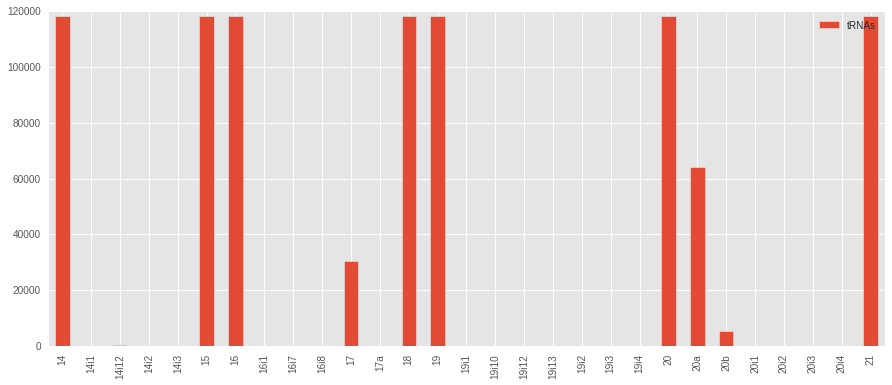

In [6]:
dloop_cols = bounds_to_cols(identities.columns, 14, 21)
position_histogram(identities, dloop_cols)

With the model curated using --hand, the D loop now contains 17a, 20a, and 20b. The alignment seems to have been fixed, as we don't have a bump at 20i5 (or even 20i5-20i7) anymore.

#### 17A

What isotypes have position 17?

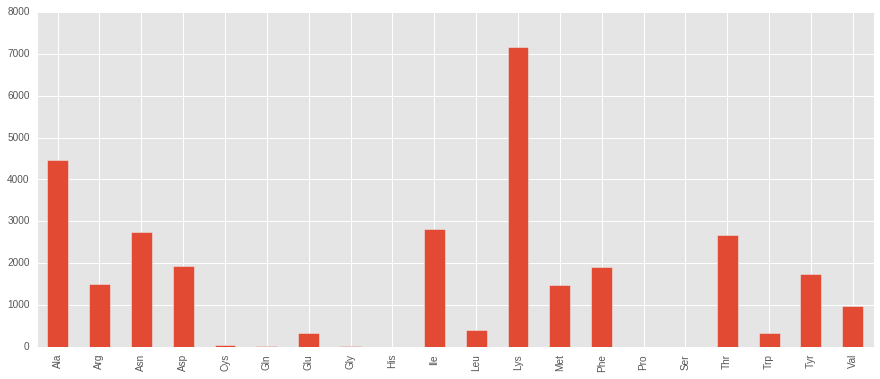

In [7]:
df = pd.melt(identities[['isotype', '17']], id_vars=['isotype'])
df = df[(df.value != ".") & (df.value != "-")]
df = pd.Series(Counter([x for x in df.isotype]))
df.plot(kind='bar')

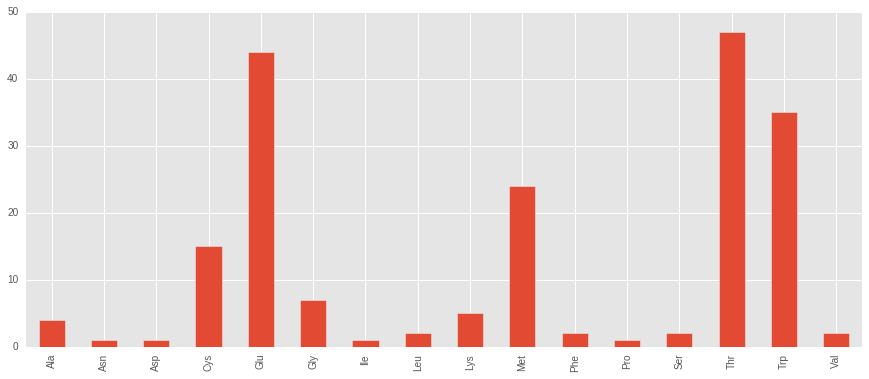

In [8]:
df = pd.melt(identities[['isotype', '17a']], id_vars=['isotype'])
df = df[(df.value != ".") & (df.value != "-")]
df = pd.Series(Counter([x for x in df.isotype]))
df.plot(kind='bar')

Based on Sprinzl alignments, there are 19 tRNAs out of 2249 with a base at position 17A. It also doesn't look like we can hardcode position 17 for just one or two isotypes - it's universal enough. Based on this data, 17A is pretty rare, and even position 17 is only there 30% of the time (based on our data). Position 17A could actually be considered as an insertion.

#### 20a/20b

** This section is somewhat deprecated as the alignment has been fixed. ** The following analysis has been modified to double check whether the new 20a/20b alignment is sound.

Also based on Sprinzl alignments, no tRNAs have only 20b and not 20a. So whenever there is 20b, 20a is sure to be there. Let's take a look at the distribution out of 2249 tRNA genes:

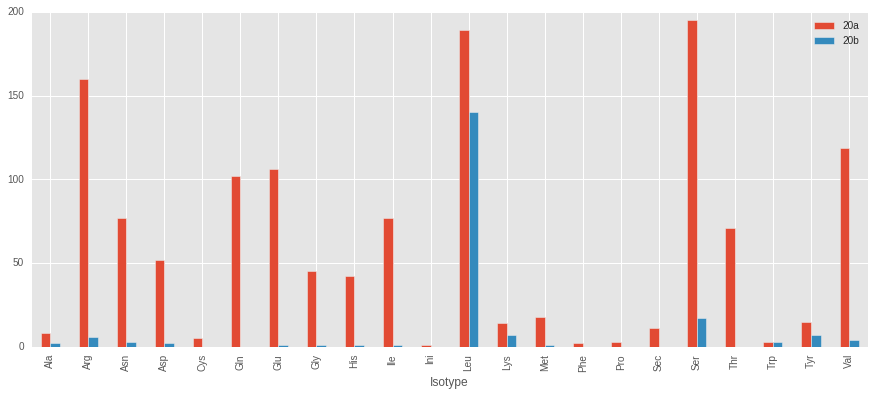

In [9]:
sprinzl_20ab = pd.read_table('sprinzl-20ab.txt', header=None, names=['20a', '20b', 'Isotype'])
sprinzl_20ab = sprinzl_20ab.groupby(["Isotype"]).aggregate(lambda x: len(x[x != '-']))
sprinzl_20ab.plot(kind="bar")

This complicates things. Ideally we'd like to see all of the tRNAs with 20b to belong to one or two isotypes. Then we could manually check the most common insertion positions for those isotypes and adjust it. Instead, we'll just have to check the insertion positions for all isotypes and attempt to come up with some universal rules.

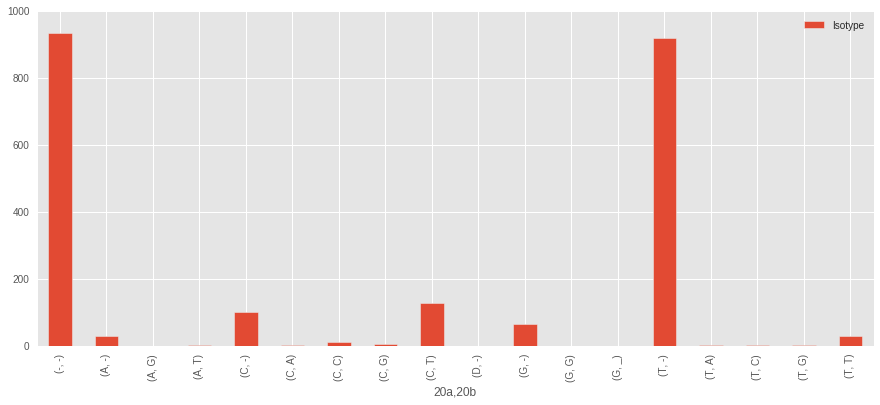

In [10]:
sprinzl_20ab = pd.read_table('sprinzl-20ab.txt', header=None, names=['20a', '20b', 'Isotype'])
sprinzl_20ab = sprinzl_20ab.groupby(["20a", "20b"]).aggregate(len)
sprinzl_20ab.plot(kind="bar")

This plot tells us a few things.

First, 20a is typically a T, but there are a few ACG 20as. To be expected, as 20ab are typically modified to dihydrouridine (D).

20b is typically also a T, but is most commonly paired with C20a. There are a few of the others, too. [Nissan and Perona (2000)](https://www.ncbi.nlm.nih.gov/pubmed/11105758) corroborate this by showing a successful replacement of  yeast function serine U20a/G20b with C20a/A20b _in vitro_. This complicates things. 

I hesitate to use a rule like "First base is 20a, second base is 20b, third and up is 20i". There is high potential for misannotation of an insertion as 20ab or vice versa. We can agree on the following:
- single base insertion: 20a
- two base insertion: 20a, 20b

For three and up, we could potentially leave it unannotated. Let's take a look at the relative insertion lengths, by isotype:

In [11]:
insert_df = identities[['isotype'] + ['20a', '20b', '20i1', '20i2', '20i3', '20i4']]
insertionab = insert_df.ix[:, 1:].apply(lambda x: sum((x != '.') & (x != '-')), axis=1)
insert_df = insert_df.assign(insertionab = insertionab)

             isotype
insertionab         
0              54030
1              58994
2               5260
3                 20
4                 13
5                  3
6                  3


[(-1, 5)]

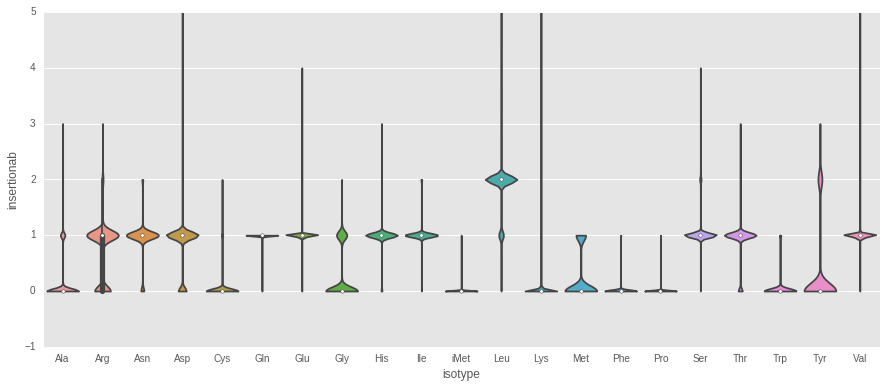

In [12]:
print(insert_df.groupby('insertionab').aggregate({"isotype": len}))
plot = sns.violinplot(data=insert_df, x='isotype', y='insertionab', scale='width', cut=0)
plot.set(ylim=(-1, 5))

Half of the tRNAs have no 20a/20b, and the other half does. For 10 isotypes, all tRNAs are 2 insertions and below. For the other 10, it varies. Exactly how many tRNAs are we working with here? Is there a correlation betweeen number of tRNAs and number of tRNAs with insertions > 2?

No. tRNAs with > 2 insertions: 39


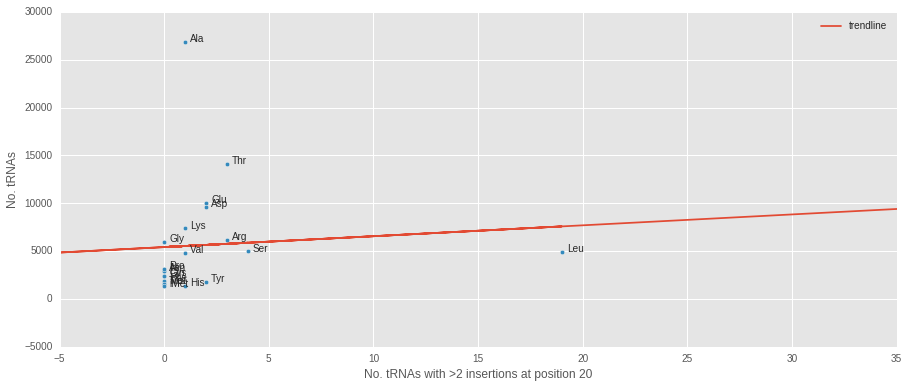

In [13]:
df = insert_df.ix[insert_df.insertionab > 2, ['isotype', 'insertionab']].groupby('isotype').aggregate(len)
print("No. tRNAs with > 2 insertions: {}".format(sum(df.insertionab)))
df = df.merge(identities[['isotype', 'seqname']].groupby('isotype').aggregate(len), how='right', right_index=True, left_index=True)
df = df.fillna(0)
df.columns = ['insertionab_tRNAs', 'tRNAs']

# scatter plot
plot = df.plot(kind='scatter', x='insertionab_tRNAs', y='tRNAs')
for isotype, num_tRNAs in df.iterrows(): plot.annotate(isotype, num_tRNAs, xytext=(5, 0), textcoords='offset points', family='sans-serif')

# add trendline
beta = numpy.polyfit(x=df.insertionab_tRNAs, y=df.tRNAs, deg=1)
trendline = pd.DataFrame({'x': list(df.insertionab_tRNAs) + [-20, 120], 'trendline': numpy.poly1d(beta)(list(df.insertionab_tRNAs) + [-20, 120])})
trendline.plot(ax=plot, x='x', y='trendline', kind='line', xlim=[-5, 35], ylim=[-5000, 30000])

plot.set_xlabel('No. tRNAs with >2 insertions at position 20')
plot.set_ylabel('No. tRNAs')

There's only 38 tRNAs with a 3 base or larger insertion. Here they are below. They're mostly leucine tRNAs.

In [14]:
df = insert_df[insert_df.insertionab > 2]
df["seq"] = df[['20a', '20b', '20i1', '20i2', '20i3', '20i4']].apply(lambda x: ''.join(x[(x != '.') & (x != '-')]), axis=1)
df.sort_values('insertionab')[['isotype', 'seq']]

/projects/lowelab/users/blin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,isotype,seq
8755,Ala,CAA
112990,Tyr,UUC
75151,Leu,CCU
75969,Leu,CUC
76801,Leu,CUC
76833,Leu,CUC
91251,Ser,UCC
94904,Ser,UUG
74649,Leu,CUA
94905,Ser,UUG


### Variable stem-loop plus spacer nucleotides

** This section is somewhat deprecated as the alignment has been fixed. ** The following analysis has been modified to double check whether the position 47 and V-arm alignment is sound.

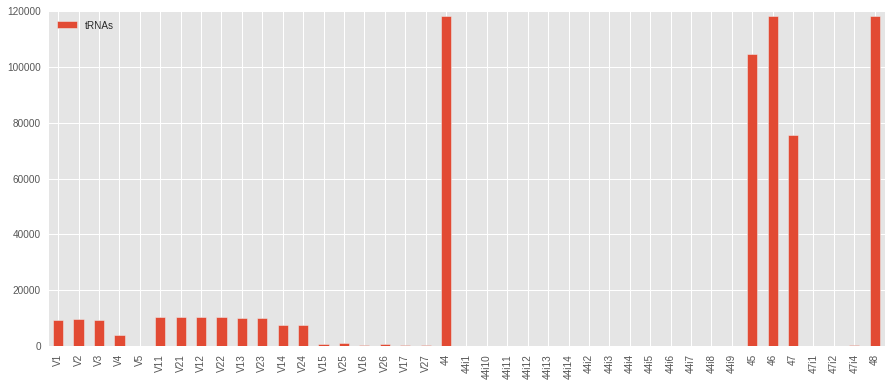

In [15]:
varm_cols = list(filter(lambda x: ('V' in x) & (':' not in x), identities.columns))
varm_cols += bounds_to_cols(identities.columns, 44, 48)
position_histogram(identities, varm_cols)

This data correlates well with the Sprinzl data. Most variable stems are missing at least V15:V25, V16:V26, and V17:V27, and most variable loops are 3 nucleotides long.

Here is the same plot, but split into Ser, Leu, and Tyr, versus everything else.

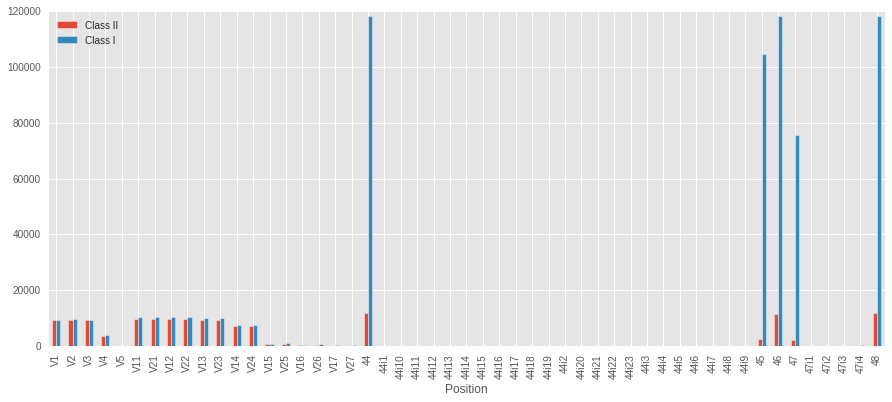

In [16]:
df = pd.melt(identities[varm_cols + ['seqname', 'isotype']], id_vars=['seqname', 'isotype'])
df = df[(df.value != ".") & (df.value != "-")]
counts = pd.Series(Counter([x for x in df[(df.isotype == "Tyr") | (df.isotype == "Leu") | (df.isotype == "Ser")].variable]), index=varm_cols)
counts = pd.DataFrame({"Position": counts.index, 'tRNAs': counts})
counts2 = pd.Series(Counter([x for x in df[(df.isotype != "Tyr") | (df.isotype != "Leu") | (df.isotype != "Ser")].variable]), index=varm_cols)
counts = pd.merge(counts, pd.DataFrame({"Position": counts2.index, 'tRNAs': counts2}), on=['Position'])
counts.columns = ['Position', 'Class II', 'Class I']
counts.index = counts.Position
counts.plot(kind='bar')

We need to apply a similar analysis for 47 as we did for 20ab. What does the distribution of 47 + insert length look like?

In [17]:
insert_df = identities[['isotype', '47', '47i1', '47i2', '47i3', '47i4']]
insert_df.head()
insertion47 = 5 - sum([(insert_df.ix[:, 1] == "."), (insert_df.ix[:, 2] == "."), (insert_df.ix[:, 3] == "."), (insert_df.ix[:, 4] == "."), (insert_df.ix[:, 5] == "."), (insert_df.ix[:, 1] == "-"), (insert_df.ix[:, 2] == "-"), (insert_df.ix[:, 3] == "-"), (insert_df.ix[:, 4] == "-"), (insert_df.ix[:, 5] == "-")])
insert_df = insert_df.assign(insertion47 = insertion47)
print(insert_df.groupby('insertion47').aggregate({"isotype": len}))

             isotype
insertion47         
0              42544
1              75304
2                467
3                  6
4                  1
5                  1


Of the 94197 tRNAs with 1 nucleotide at position 47 + 47ix, which position does it appear on? Is there a typical position 47 nucleotide?

,isotype,variable,value
151825,Ala,47i2,A
327661,Arg,47i4,U


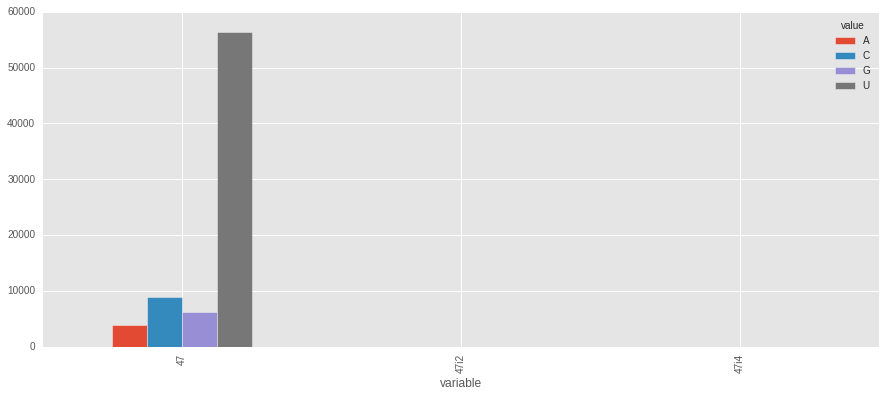

In [18]:
df = pd.melt(insert_df.ix[insert_df.insertion47 == 1, 0:6], id_vars='isotype')
df = df[(df.value != "-") & (df.value != '.')]
df[['variable', 'value']].groupby(['variable', 'value']).aggregate(len).unstack().plot(kind='bar')
df.ix[df.variable != "47", :]

There are literally 2 cases where a single base is not aligned to position 47 properly, and there are no cases where 2 bases are both aligned to insertion positions.

## Annotate tertiary interactions

We also want to annotate the 2-base version of the base triples. This makes checking for conserved interactions (e.g. an identity element) a bit easier. It's important to remember to consider the 3rd base pair too, though.

In [19]:
identities['8:14:21'] = identities.ix[:, ["8", "14", "21"]].apply(lambda row: ':'.join(row), axis=1)
identities['8:14'] = identities.ix[:, ["8", "14"]].apply(lambda row: ':'.join(row), axis=1)
identities['9:12:23'] = identities.ix[:, ["9", "12", "23"]].apply(lambda row: ':'.join(row), axis=1)
identities['9:23'] = identities.ix[:, ["9", "23"]].apply(lambda row: ':'.join(row), axis=1)
identities['10:25:45'] = identities.ix[:, ["10", "25", "45"]].apply(lambda row: ':'.join(row), axis=1)
identities['10:45'] = identities.ix[:, ["10", "45"]].apply(lambda row: ':'.join(row), axis=1)
identities['13:22:46'] = identities.ix[:, ["13", "22", "46"]].apply(lambda row: ':'.join(row), axis=1)
identities['22:46'] = identities.ix[:, ["22", "46"]].apply(lambda row: ':'.join(row), axis=1)
identities['15:48'] = identities.ix[:, ["15", "48"]].apply(lambda row: ':'.join(row), axis=1)
identities['18:55'] = identities.ix[:, ["18", "55"]].apply(lambda row: ':'.join(row), axis=1)
identities['19:56'] = identities.ix[:, ["19", "56"]].apply(lambda row: ':'.join(row), axis=1)
identities['26:44'] = identities.ix[:, ["26", "44"]].apply(lambda row: ':'.join(row), axis=1)
identities['54:58'] = identities.ix[:, ["54", "58"]].apply(lambda row: ':'.join(row), axis=1)

## Additional sequence information

In [20]:
# Isotype, anticodon, score
seqinfo = []
for isotype in isotypes:
  alignment = 'alignments/euk-' + isotype + '.sto'
  for line in open(alignment):
    if line[0:4] != "#=GS": continue
    _, seqname, _, _, _, isotype, anticodon, _, _, _, score, _, isoscore = line.strip().split()
    seqinfo.append([seqname, isotype, anticodon[1:-1], float(score), float(isoscore)])
seqinfo = pd.DataFrame(seqinfo, columns=['seqname', 'isotype_ac', 'anticodon', 'score', 'isoscore'])
identities = identities.merge(seqinfo, on='seqname')

# GC content
paired_cols = identities.columns[list(map(lambda x: (':' in x), identities.columns))]
identities['GC'] = identities[paired_cols].apply(lambda x: sum((x == "G:C") | (x == "C:G"))/len(paired_cols), axis=1)

### Insertions/deletions/introns

In [21]:
# Intron length
intron_cols = list(filter(lambda x: x[0:3] == '37i', identities.columns))
identities['intron'] = identities[intron_cols].apply(lambda x: sum(x != "."), axis=1)

# Insertions (minus introns at 37/38)
insertion_cols = list(filter(lambda x: bool(re.search('^\d+i', x)) & (x not in intron_cols), identities.columns))
identities['insertions'] = identities[insertion_cols].apply(lambda x: sum(x != '.'), axis=1)

# Deletions at positions that are not the variable arm, and not counting 17/17a/20a/20b
base_cols = list(filter(lambda x: bool(re.match('^\d+$', x)) & (x not in ['74', '75', '76', '17', '17a', '20a', '20b']), identities.columns))
identities['deletions'] = identities[base_cols].apply(lambda x: ''.join(x).count('-'), axis=1)

### Loop sizes

In [22]:
def bounds_to_cols(cols, start, end):
  selected_cols = []
  for col in cols:
    matches = re.findall('\d+', col)
    if len(matches) < 1: continue
    index = int(matches[0])
    if (index >= start and index <= end or col[0:3] == '{}i'.format(start - 1)) and col[0] != 'V':
      selected_cols.append(col)
  return selected_cols

dloop_cols = list(filter(lambda col: ':' not in col, bounds_to_cols(identities.columns, 14, 21)))
identities['D-loop'] = identities[dloop_cols].apply(lambda x: len(x[(x != '.') & (x != '-')]), axis=1)

# Leu, Ser, Tyr have a 3 bp D stem
dloop_II_cols = list(filter(lambda col: ':' not in col, bounds_to_cols(identities.columns, 13, 22)))
identities.ix[(identities.isotype == 'Leu') | (identities.isotype == 'Ser') | (identities.isotype == 'Tyr'), 'D-loop'] = identities[dloop_II_cols].apply(lambda x: len(x[(x != '.') & (x != '-')]), axis=1)

acloop_cols = list(filter(lambda x: not re.match('37i.+', x), bounds_to_cols(identities.columns, 32, 38)))
identities['AC-loop'] = identities[acloop_cols].apply(lambda x: len(x[(x != '.') & (x != '-')]), axis=1)

tpcloop_cols = bounds_to_cols(identities.columns, 54, 60)
identities['TPC-loop'] = identities[tpcloop_cols].apply(lambda x: len(x[(x != '.') & (x != '-')]), axis=1)

varm_cols = list(filter(lambda x: ('V' in x) & (':' not in x), identities.columns))
identities['V-arm'] = identities[varm_cols].apply(lambda x: len(x[(x != '.') & (x != '-') & (x != "-:-")]), axis=1)

### High-quality tRNA set

There was talk about using the high quality tRNAs to look at identity elements. Instead, I will just annotate specific tRNAs as high-quality or not. We can sort out the differences later.

In [23]:
# Import list of quality tRNAs
quality_trnas = [line.strip() for line in open('quality-set.out')]
identities['quality'] = identities.seqname.isin(quality_trnas)

### Restrict tRNAs by species

We may also want to limit the contribution of any single species, similar to how we built the isotype-specific models. The restricted set is a subset of the quality set.

In [27]:
identities.ix[:, 'restrict'] = False
for species in identities.species.unique():
  species_df = identities.ix[identities.species == species, :]
  for isotype in isotypes:
    isotype_indices = identities.ix[(identities.species == species) & (identities.isotype == isotype) & (-identities.restrict) & (identities.quality), ].index
    unique_scores_indices = isotype_indices[-identities.ix[isotype_indices, 'score'].duplicated()]
    if len(unique_scores_indices) > 50:
      unique_scores_indices = unique_scores_indices[numpy.argsort(identities.ix[unique_scores_indices, 'score'])][::-1][:50]
    restricted_indices = list(set(isotype_indices) - set(unique_scores_indices))
    identities.ix[restricted_indices, 'restrict'] = True

## Export to R

R has superior visualization capabilities.

### Order columns

To make it look pretty.

In [28]:
def position_str_to_int(position):
  if position == "20a": return 20.1
  if position == "20b": return 20.2
  digits = re.findall('\d+', position)
  if len(digits) == 0: return -1
  insert = 0
  if 'i' in position and len(digits) == 2: insert = float(digits[1]) / 1000
  if position[0] == 'V':
    if ':' in position: return int(digits[0]) + 45 - 10 + insert # V11~V17
    else: return int(digits[0]) + 45 + 7 + insert # V1~V5
  if int(digits[0]) >= 46: return int(digits[0]) + 50 + insert # just add an arbitrarily large number to skip v-arm
  return int(digits[0]) + insert

identities = identities[sorted(list(identities.columns), key=position_str_to_int)]

In [29]:
identities.to_csv(path_or_buf='identities.tsv', sep='\t', index_label=False)